In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


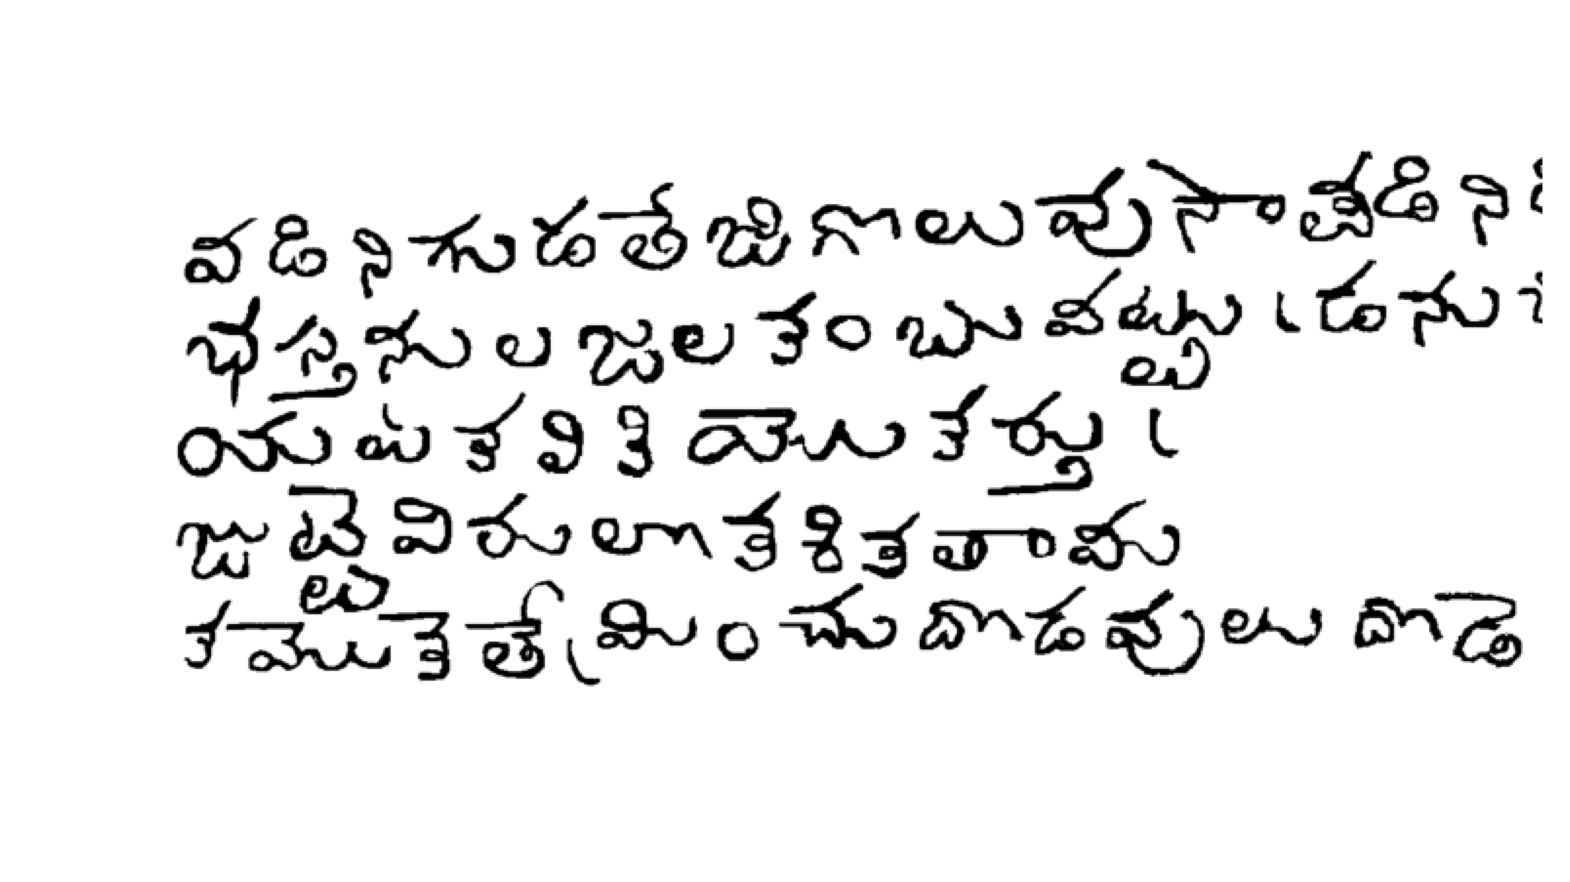

In [2]:
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt

img = imread("/content/drive/MyDrive/binarized_image.png")
plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(img, cmap="gray")
plt.show()

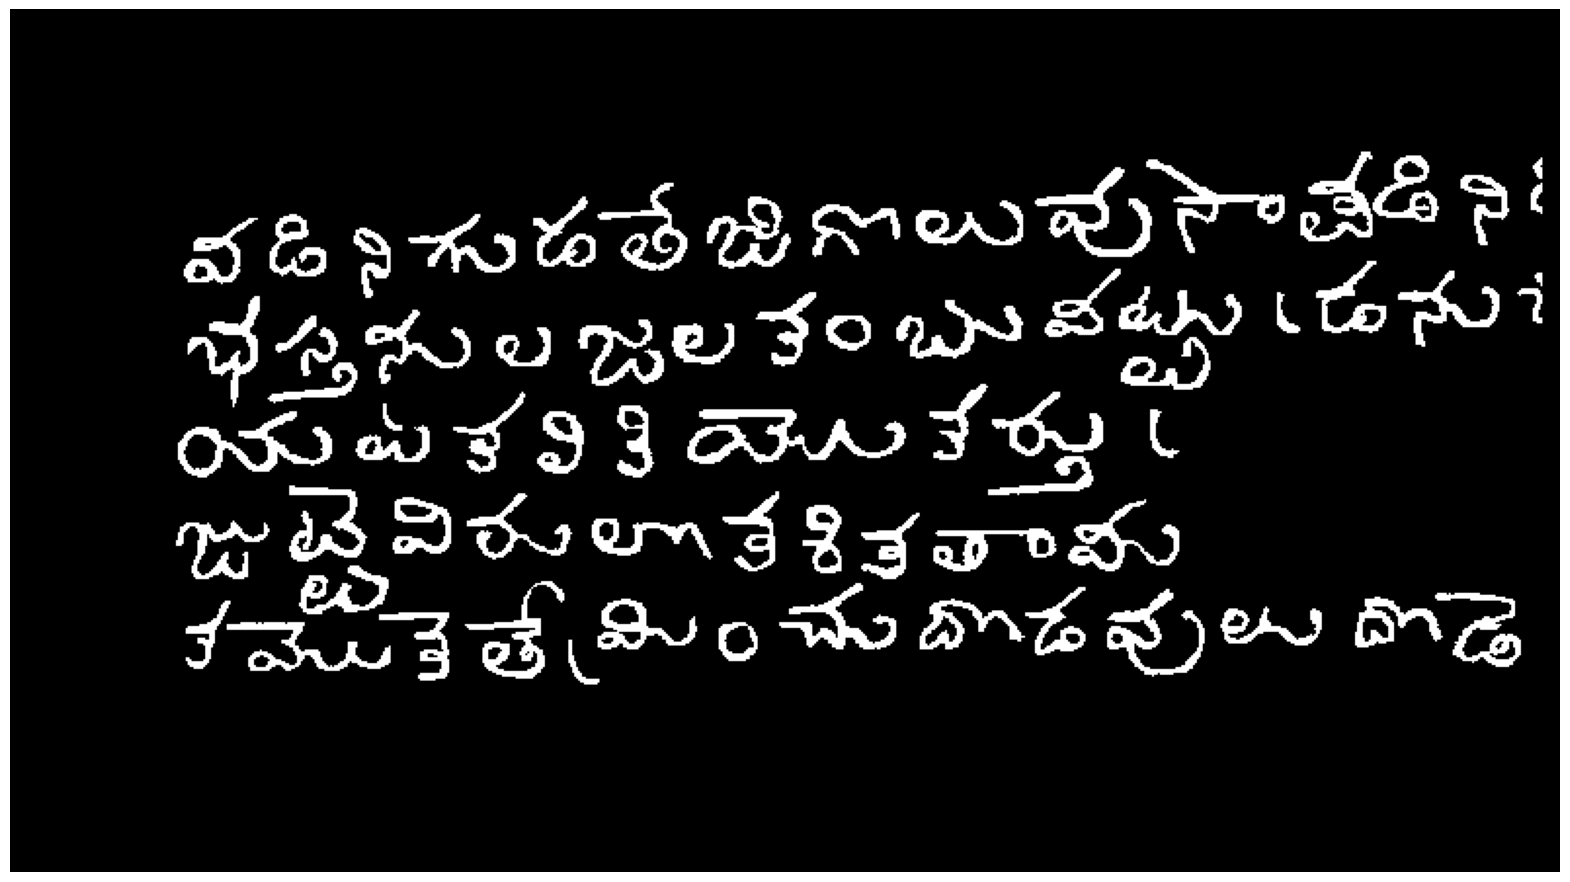

In [6]:
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'img' is your input image
# Check if the image has four channels, if so, discard the fourth channel
if img.shape[2] == 4:
    img = img[:, :, :3]  # Discard the fourth channel

img_shape = img.shape
binary_imag = np.ones(img_shape[:2])  # Only extracting rows and columns

divider = 4
for ri in range(divider):
    for ci in range(divider):
        region = img[int((ri/divider)*img_shape[0]):int((ri/divider+1/divider)*img_shape[0]),
                     int((ci/divider)*img_shape[1]):int((ci/divider+1/divider)*img_shape[1])]
        # Convert the RGB region to grayscale
        region_gray = rgb2gray(region)
        # Apply Otsu's thresholding to the grayscale region
        thresh = threshold_otsu(region_gray)
        binary_imag[int((ri/divider)*img_shape[0]):int((ri/divider+1/divider)*img_shape[0]),
                     int((ci/divider)*img_shape[1]):int((ci/divider+1/divider)*img_shape[1])] = region_gray < thresh

plt.figure(figsize=(20,20))
plt.axis("off")
plt.imshow(binary_imag, cmap="gray")
plt.show()


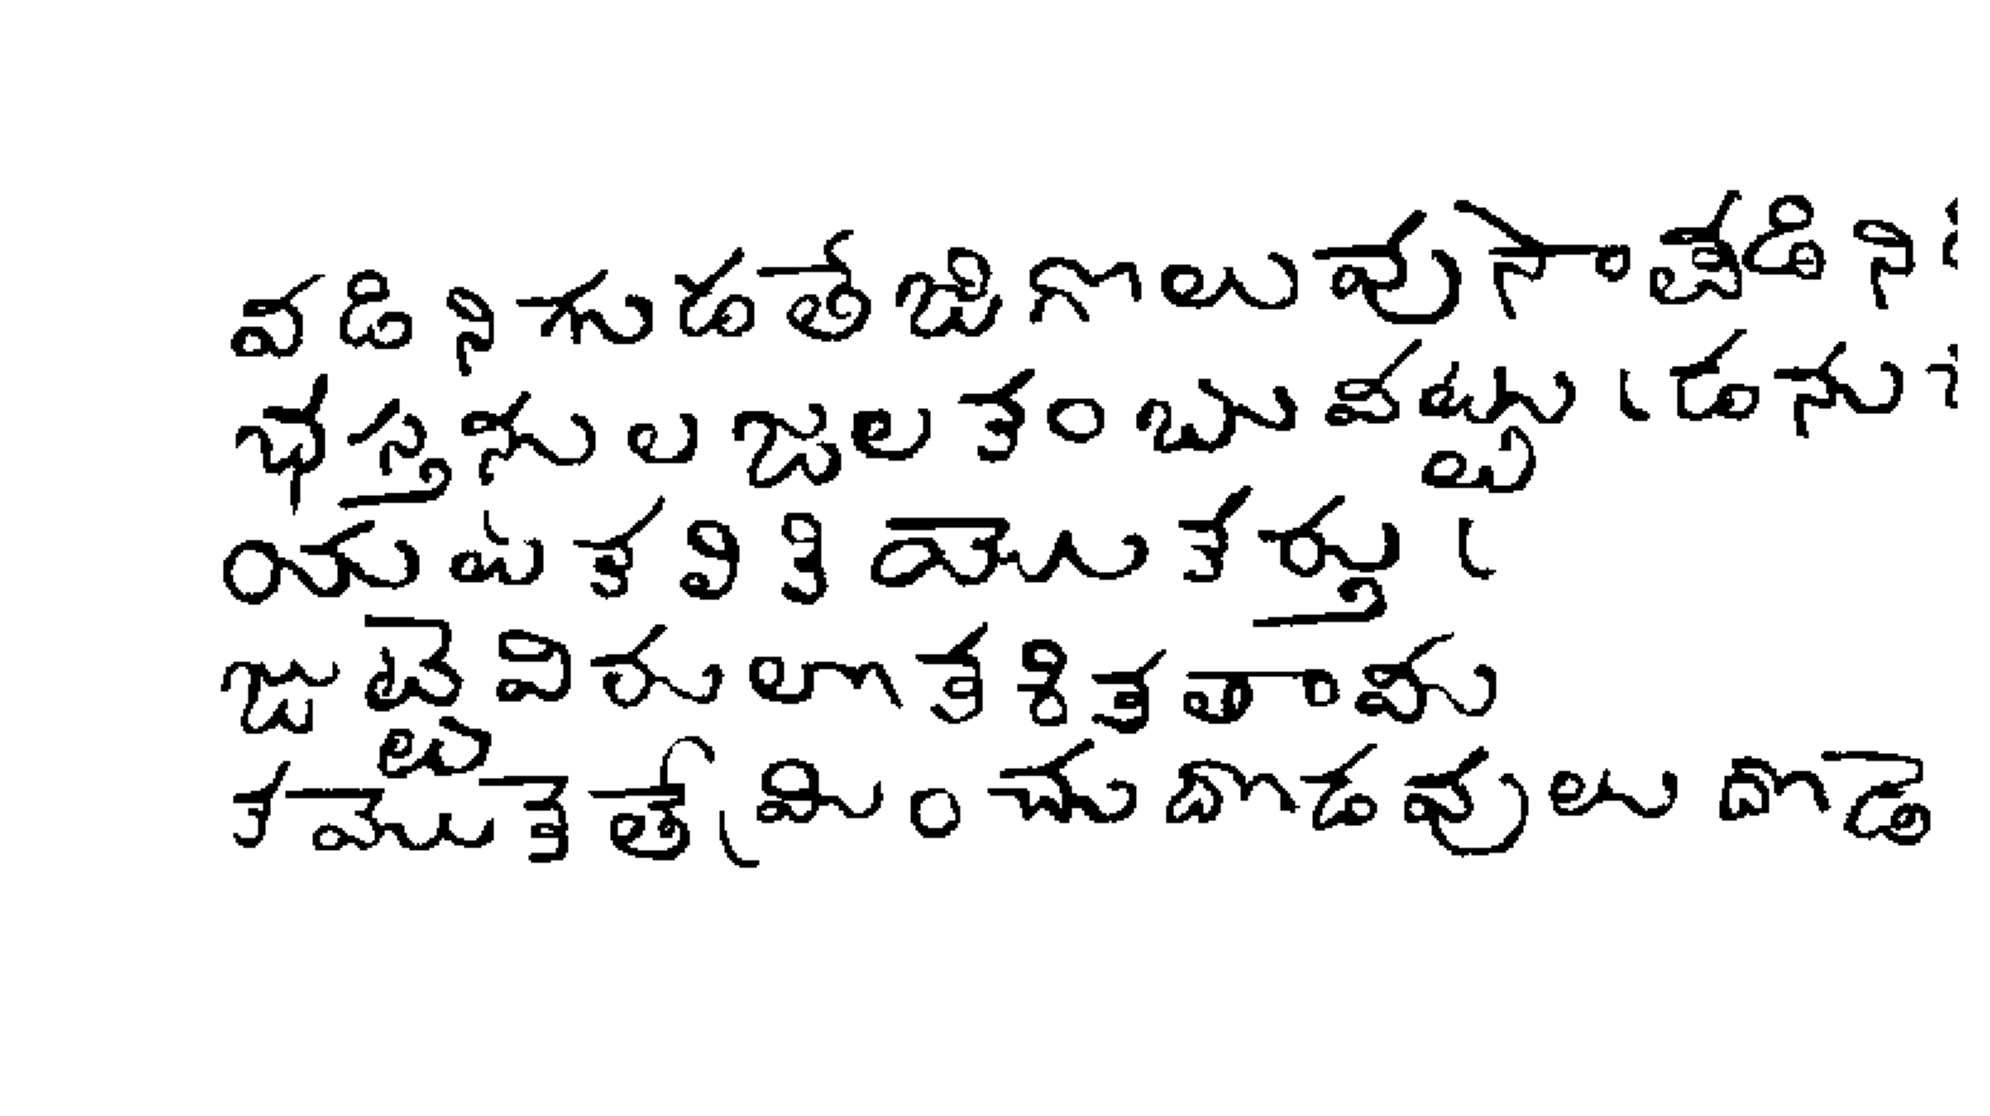

In [7]:
from skimage.measure import label, regionprops
from skimage.util import invert

label_image = label(binary_imag)

fig, ax = plt.subplots(figsize=(20,20))

image_blocks = []
for region in regionprops(label_image):
    minr, minc, maxr, maxc = region.bbox
    height = maxr - minr
    width = maxc - minc
    # if height is more than 75% of the image, clear it from the image.
    if height > binary_imag.shape[0]*0.75:
        coords = region.coords
        for coord in coords:
            binary_imag[coord[0],coord[1]] = 0
    elif region.area < 15 or region.extent < 0.05 or height/width < 0.06:
        coords = region.coords
        for coord in coords:
            binary_imag[coord[0],coord[1]] = 0
    else:
        image_blocks.append(region)

ax.imshow(invert(binary_imag), cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

<ipython-input-19-fb85640675b4>:8: UserWarning: threshold_otsu is expected to work correctly only for grayscale images; image shape (442, 794, 3) looks like that of an RGB image.
  threshold = threshold_otsu(img)


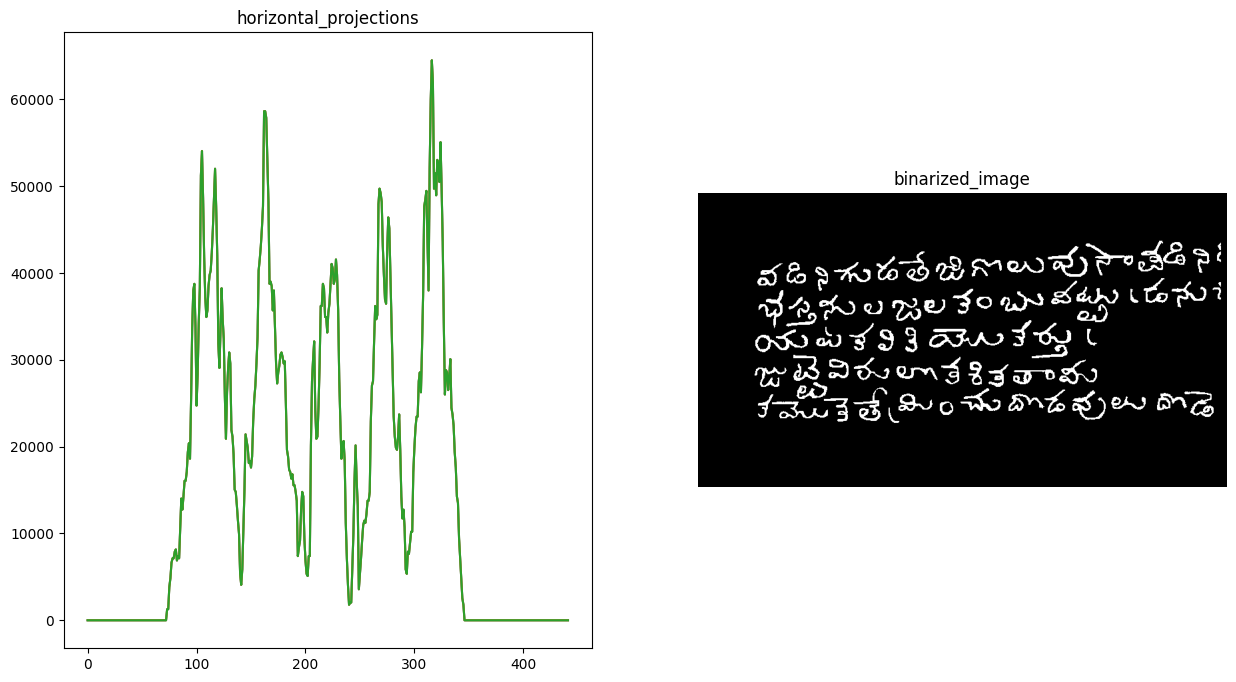

In [19]:
from skimage.filters import threshold_otsu
import numpy as np

def horizontal_projections(sobel_image):
    return np.sum(sobel_image, axis=1)

def binarize_image(image):
    threshold = threshold_otsu(img)
    binarized = image < threshold
    return binarized.astype(np.uint8) * 255


binarized_image = binarize_image(img)
hpp = horizontal_projections(binarized_image)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax1.set_title("horizontal_projections")
ax1.plot(hpp)

ax2.axis("off")
ax2.set_title("binarized_image")

ax2.imshow(binarized_image, cmap="gray")
plt.savefig("binarized_image.png")

plt.show()

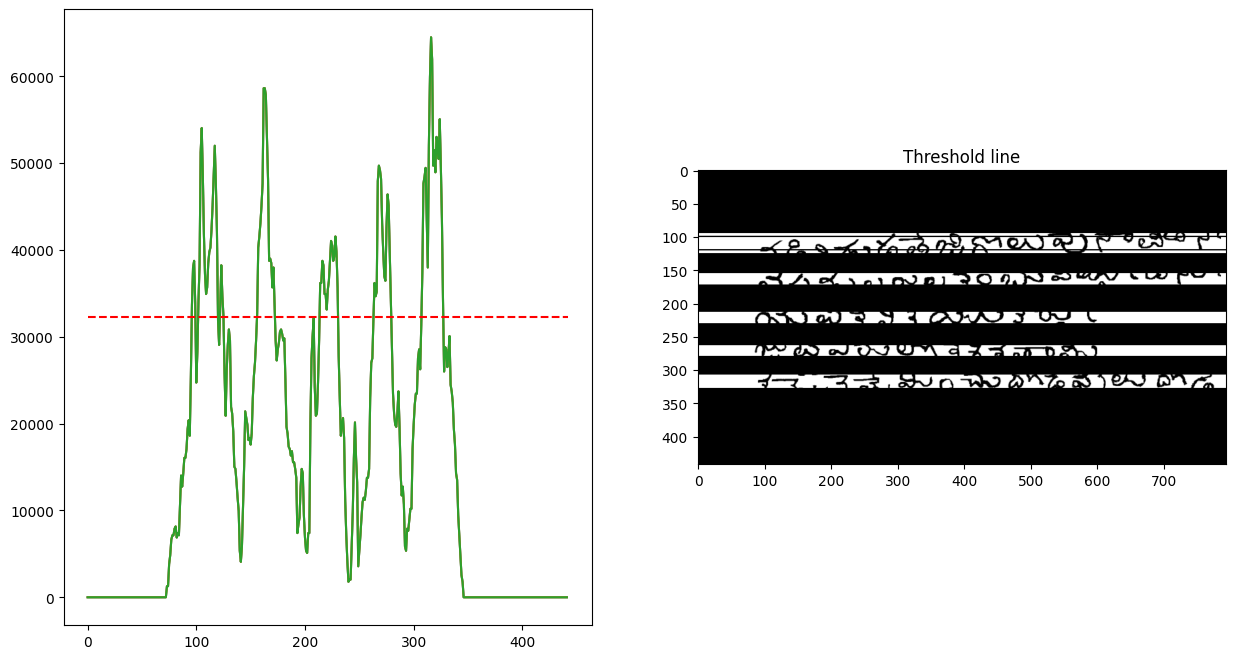

In [20]:
# find the midway where we can make a threshold and extract the peaks regions
def find_peak_regions(hpp, threshold):
    peaks = np.where(hpp < threshold)[0]
    return peaks

# find the threshold from where anything above is considered a peak region
# using the average for now but this needs further research. This may or may not work on all images.
threshold = (np.max(hpp) - np.min(hpp)) / 2
peaks = find_peak_regions(hpp, threshold)

segmented_img = np.copy(img)
segmented_img[peaks, :] = 0

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
ax1.plot(hpp)
ax1.plot([0, img.shape[0]], [threshold, threshold], linestyle='--', color='red')
ax2.set_title("Threshold line")
ax2.imshow(segmented_img, cmap="gray")
plt.show()


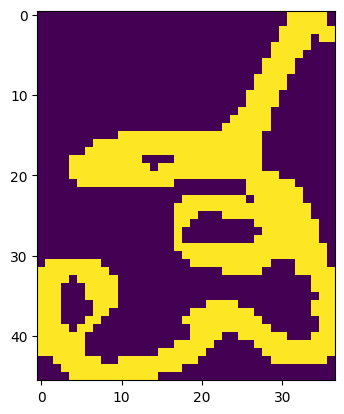

In [28]:
def show_image_in_region(region):
    minr, minc, maxr, maxc = region.bbox
    plt.imshow(binary_imag[minr:maxr,minc:maxc])
show_image_in_region(image_blocks[0])